In [1]:
import os
import numpy as np
from scipy.stats import kendalltau
from collections import defaultdict
from operator import itemgetter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from geomloss import SamplesLoss
from sklearn.model_selection import KFold
import rouge
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from config_models import *
from datasets import *
from models import *
from preprocessing import *

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

torch.manual_seed(42)
# torch.set_default_tensor_type(torch.cuda.DoubleTensor)
cuda = torch.device('cuda:0')

[nltk_data] Downloading package punkt to /home/korunosk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATASET_ID_TRAIN = DATASET_IDS[0]
DATASET_ID_TEST = DATASET_IDS[1]
TOPIC_ID_TRAIN = TOPIC_IDS[DATASET_ID_TRAIN][0]
TOPIC_ID_TEST = TOPIC_IDS[DATASET_ID_TEST][0]
BASE_DATA_DIR = '/scratch/korunosk/data'
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'BERT_sent')

Train Loss: 69.3115
Train Loss: 69.3682
Train Loss: 69.0068
Train Loss: 68.6074
Train Loss: 69.4068
Train Loss: 67.8983
Train Loss: 67.6261
Train Loss: 69.5091
Train Loss: 66.9451
Train Loss: 67.5870
Train Loss: 68.3892
Train Loss: 67.5651
Train Loss: 64.9122
Train Loss: 65.6016
Train Loss: 63.7798
Train Loss: 62.6840
Train Loss: 64.0375
Train Loss: 64.5804
Train Loss: 62.9499
Train Loss: 65.5837
Train Loss: 63.2976
Train Loss: 59.6295
Train Loss: 64.4138
Train Loss: 59.7852
Train Loss: 60.5601
Train Loss: 61.9247
Train Loss: 59.3894
Train Loss: 60.5314
Train Loss: 61.2673
Train Loss: 56.7187
Train Loss: 54.4711
Train Loss: 53.7513
Train Loss: 57.6689
Train Loss: 58.3349
Train Loss: 54.3594
Train Loss: 54.7867
Train Loss: 62.0022
Train Loss: 63.4338
Train Loss: 53.5892
Train Loss: 57.4711
Train Loss: 50.8743
Train Loss: 56.3246
Train Loss: 56.5553
Train Loss: 53.0958
Train Loss: 51.7751
Train Loss: 52.1722
Train Loss: 52.3478
Train Loss: 54.7603
Train Loss: 51.9367
Train Loss: 52.3721


Train Loss: 28.5960
Train Loss: 18.6405
Train Loss: 20.9972
Train Loss: 22.7844
Train Loss: 31.1955
Train Loss: 33.7951
Train Loss: 21.2930
Train Loss: 18.2313
Train Loss: 29.4886
Train Loss: 22.1050
Train Loss: 26.5346
Train Loss: 24.3029
Train Loss: 20.0923
Train Loss: 25.8766
Train Loss: 27.8074
Train Loss: 21.1517
Train Loss: 24.3895
Train Loss: 23.2380
Train Loss: 25.5331
Train Loss: 22.5010
Train Loss: 28.5703
Train Loss: 29.8020
Train Loss: 18.5556
Train Loss: 30.0627
Train Loss: 22.8303
Train Loss: 28.6065
Train Loss: 20.4862
Train Loss: 29.4376
Train Loss: 20.8762
Train Loss: 28.5397
Train Loss: 22.9740
Train Loss: 32.8360
Train Loss: 19.0081
Train Loss: 19.9830
Train Loss: 19.0119
Train Loss: 24.4866
Train Loss: 35.8389
Train Loss: 25.8093
Train Loss: 18.6325
Train Loss: 30.9190
Train Loss: 23.2842
Train Loss: 20.0474
Train Loss: 24.2622
Train Loss: 18.6294
Train Loss: 30.1692
Train Loss: 14.0329
Train Loss: 24.6586
Train Loss: 15.7685
Train Loss: 32.0690
Train Loss: 20.5049


Train Loss: 21.8360
Train Loss: 25.9650
Train Loss: 15.9682
Train Loss: 23.4492
Train Loss: 25.0638
Train Loss: 20.8756
Train Loss: 12.9590
Train Loss: 21.2350
Train Loss: 19.9589
Train Loss: 20.8445
Train Loss: 20.1274
Train Loss: 35.7600
Train Loss: 18.3535
Train Loss: 24.2244
Train Loss: 30.4302
Train Loss: 13.1226
Train Loss: 12.3812
Train Loss: 28.2645
Train Loss: 18.1153
Train Loss: 20.5623
Train Loss: 21.9354
Train Loss: 21.9504
Train Loss: 31.4774
Train Loss: 15.3965
Train Loss: 23.8475
Train Loss: 15.8237
Train Loss: 26.2067
Train Loss: 21.0969
Train Loss: 18.1897
Train Loss: 17.0473
Train Loss: 22.2763
Train Loss: 19.8704
Train Loss: 18.9125
Train Loss: 31.4631
Train Loss: 23.3706
Train Loss: 13.0657
Train Loss: 17.3644
Train Loss: 20.5082
Train Loss: 14.8422
Train Loss: 27.6337
Train Loss: 16.0303
Train Loss: 18.4120
Train Loss: 19.7932
Train Loss: 17.7766
Train Loss: 19.4904
Train Loss: 27.5998
Train Loss: 14.4990
Train Loss: 18.0320
Train Loss: 15.2149
Train Loss: 19.1025


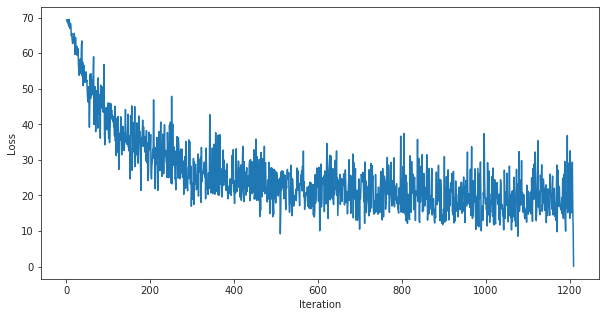

Train Loss: 69.3367
Train Loss: 69.3568
Train Loss: 69.0916
Train Loss: 68.6959
Train Loss: 68.4081
Train Loss: 68.7084
Train Loss: 68.4075
Train Loss: 67.8389
Train Loss: 67.5094
Train Loss: 68.2754
Train Loss: 68.0976
Train Loss: 68.2715
Train Loss: 65.3977
Train Loss: 65.9925
Train Loss: 65.3844
Train Loss: 62.1595
Train Loss: 66.1638
Train Loss: 62.2943
Train Loss: 67.1878
Train Loss: 62.9226
Train Loss: 61.9454
Train Loss: 63.2976
Train Loss: 63.5364
Train Loss: 59.9559
Train Loss: 61.5409
Train Loss: 57.0938
Train Loss: 63.8917
Train Loss: 57.7431
Train Loss: 66.0919
Train Loss: 59.8280
Train Loss: 57.9432
Train Loss: 52.8779
Train Loss: 56.3412
Train Loss: 60.3132
Train Loss: 58.1592
Train Loss: 59.3855
Train Loss: 55.4247
Train Loss: 57.9133
Train Loss: 55.3765
Train Loss: 51.3934
Train Loss: 58.5183
Train Loss: 55.8566
Train Loss: 55.0331
Train Loss: 60.5841
Train Loss: 59.6105
Train Loss: 52.0466
Train Loss: 55.6327
Train Loss: 49.5311
Train Loss: 54.1113
Train Loss: 49.2971


Train Loss: 26.5877
Train Loss: 18.3440
Train Loss: 31.0866
Train Loss: 21.9263
Train Loss: 35.3897
Train Loss: 21.7527
Train Loss: 23.6802
Train Loss: 21.2256
Train Loss: 24.0983
Train Loss: 29.1729
Train Loss: 25.8660
Train Loss: 25.6625
Train Loss: 26.7236
Train Loss: 26.5312
Train Loss: 26.6914
Train Loss: 27.2397
Train Loss: 15.2824
Train Loss: 21.7301
Train Loss: 22.6367
Train Loss: 20.2553
Train Loss: 22.7790
Train Loss: 24.4819
Train Loss: 21.6159
Train Loss: 18.9748
Train Loss: 23.2711
Train Loss: 20.0577
Train Loss: 28.4967
Train Loss: 14.0044
Train Loss: 27.6089
Train Loss: 27.1123
Train Loss: 26.7728
Train Loss: 28.7596
Train Loss: 23.6836
Train Loss: 28.9219
Train Loss: 23.4389
Train Loss: 25.7328
Train Loss: 19.5054
Train Loss: 34.0867
Train Loss: 19.1875
Train Loss: 25.5546
Train Loss: 15.3268
Train Loss: 23.1160
Train Loss: 31.6153
Train Loss: 21.1777
Train Loss: 21.9911
Train Loss: 22.4522
Train Loss: 19.4344
Train Loss: 26.7600
Train Loss: 19.1088
Train Loss: 23.2329


Train Loss: 19.7075
Train Loss: 25.8030
Train Loss: 22.7486
Train Loss: 16.0076
Train Loss: 13.6824
Train Loss: 29.0021
Train Loss: 21.7274
Train Loss: 22.7571
Train Loss: 19.2775
Train Loss: 24.4612
Train Loss: 25.9007
Train Loss: 17.7682
Train Loss: 20.4220
Train Loss: 17.3621
Train Loss: 21.0225
Train Loss: 20.1423
Train Loss: 22.3273
Train Loss: 18.4495
Train Loss: 23.1341
Train Loss: 27.9582
Train Loss: 14.1272
Train Loss: 17.5793
Train Loss: 18.8434
Train Loss: 12.8977
Train Loss: 22.1966
Train Loss: 22.6068
Train Loss: 25.1610
Train Loss: 27.2037
Train Loss: 13.4224
Train Loss: 12.5022
Train Loss: 16.9657
Train Loss: 21.9048
Train Loss: 15.9065
Train Loss: 39.0612
Train Loss: 16.8516
Train Loss: 25.1477
Train Loss: 15.5719
Train Loss: 30.8817
Train Loss: 26.8600
Train Loss: 22.6213
Train Loss: 16.6043
Train Loss: 20.3302
Train Loss: 23.2261
Train Loss: 14.1995
Train Loss: 17.9162
Train Loss: 23.3249
Train Loss: 21.9693
Train Loss: 18.9118
Train Loss: 20.8958
Train Loss: 21.4768


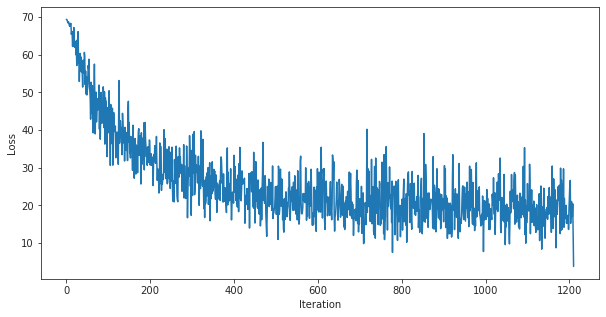

Train Loss: 69.3546
Train Loss: 69.2415
Train Loss: 69.1463
Train Loss: 68.7105
Train Loss: 69.1920
Train Loss: 67.8560
Train Loss: 67.8494
Train Loss: 67.1530
Train Loss: 68.0009
Train Loss: 66.9300
Train Loss: 65.8840
Train Loss: 67.8708
Train Loss: 65.3366
Train Loss: 61.5109
Train Loss: 64.0688
Train Loss: 62.8749
Train Loss: 64.4184
Train Loss: 62.1374
Train Loss: 67.2542
Train Loss: 66.0804
Train Loss: 60.5596
Train Loss: 65.6652
Train Loss: 62.7002
Train Loss: 61.9586
Train Loss: 66.1384
Train Loss: 62.2862
Train Loss: 58.4928
Train Loss: 61.9647
Train Loss: 59.1785
Train Loss: 60.3696
Train Loss: 55.3768
Train Loss: 60.4119
Train Loss: 57.0982
Train Loss: 57.5625
Train Loss: 56.9681
Train Loss: 57.3509
Train Loss: 51.8012
Train Loss: 59.5110
Train Loss: 57.2749
Train Loss: 53.1938
Train Loss: 47.4797
Train Loss: 52.8450
Train Loss: 57.2070
Train Loss: 51.3868
Train Loss: 48.9020
Train Loss: 50.6639
Train Loss: 51.0107
Train Loss: 56.8894
Train Loss: 48.5344
Train Loss: 60.7672


Train Loss: 33.2684
Train Loss: 29.6408
Train Loss: 25.8993
Train Loss: 23.9663
Train Loss: 15.4929
Train Loss: 21.8939
Train Loss: 34.1423
Train Loss: 22.8381
Train Loss: 18.3679
Train Loss: 22.1578
Train Loss: 24.7273
Train Loss: 23.1811
Train Loss: 23.0894
Train Loss: 21.8705
Train Loss: 20.7719
Train Loss: 21.9220
Train Loss: 21.8713
Train Loss: 26.7334
Train Loss: 27.3216
Train Loss: 31.6906
Train Loss: 26.5164
Train Loss: 29.3484
Train Loss: 18.7750
Train Loss: 19.8961
Train Loss: 25.9210
Train Loss: 26.2897
Train Loss: 20.4718
Train Loss: 24.8432
Train Loss: 19.5495
Train Loss: 22.0170
Train Loss: 19.7248
Train Loss: 30.8088
Train Loss: 18.6396
Train Loss: 21.5981
Train Loss: 28.1686
Train Loss: 15.8855
Train Loss: 20.9733
Train Loss: 23.2605
Train Loss: 20.3117
Train Loss: 28.4367
Train Loss: 19.1749
Train Loss: 16.6847
Train Loss: 22.0626
Train Loss: 28.4729
Train Loss: 20.8680
Train Loss: 17.1397
Train Loss: 21.6455
Train Loss: 19.2601
Train Loss: 16.4905
Train Loss: 19.3457


Train Loss: 18.1882
Train Loss: 22.0558
Train Loss: 27.2770
Train Loss: 31.0924
Train Loss: 19.9367
Train Loss: 16.2696
Train Loss: 24.5791
Train Loss: 28.1679
Train Loss: 12.0413
Train Loss: 19.6256
Train Loss: 15.5760
Train Loss: 22.0976
Train Loss: 24.9324
Train Loss: 21.8653
Train Loss: 20.4066
Train Loss: 17.4554
Train Loss: 22.8354
Train Loss: 11.0354
Train Loss: 17.2716
Train Loss: 20.4118
Train Loss: 22.8612
Train Loss: 21.6984
Train Loss: 21.2348
Train Loss: 28.7482
Train Loss: 13.2273
Train Loss: 20.6128
Train Loss: 19.4606
Train Loss: 17.3078
Train Loss: 14.3793
Train Loss: 19.3054
Train Loss: 25.6719
Train Loss: 26.3384
Train Loss: 19.4224
Train Loss: 26.3910
Train Loss: 15.1817
Train Loss: 12.7811
Train Loss: 24.6804
Train Loss: 15.2308
Train Loss: 19.9195
Train Loss: 24.6409
Train Loss: 19.5079
Train Loss: 20.5578
Train Loss: 18.0004
Train Loss: 21.8230
Train Loss: 17.7634
Train Loss: 20.6768
Train Loss: 19.3146
Train Loss: 17.0547
Train Loss: 33.6519
Train Loss: 14.1101


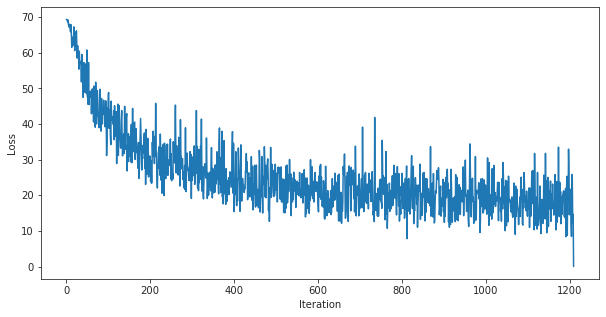

-0.18377884834891503


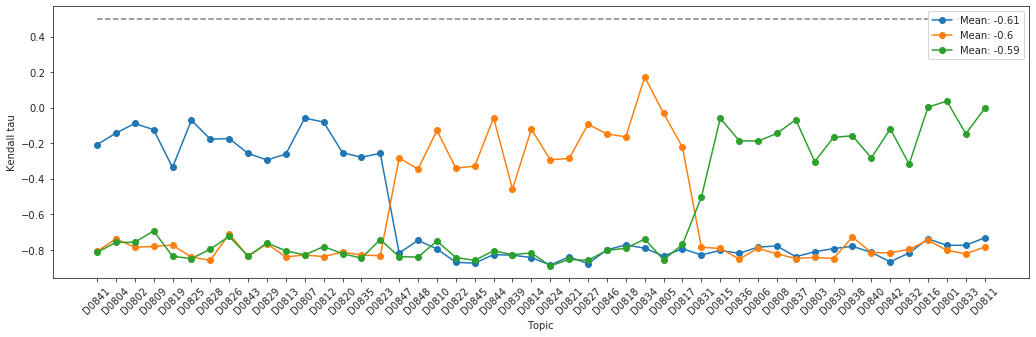

In [9]:
def execute():
    topic_ids = np.array(TOPIC_IDS[DATASET_ID_TRAIN])

    dataset = defaultdict(dict)

    for topic_id in topic_ids:
        topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
        document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)

        dataset[topic_id]['document_embs'] = np.array(document_embs)
        dataset[topic_id]['summary_embs'] = np.array(summary_embs)
        dataset[topic_id]['indices'] = np.array(indices)
        dataset[topic_id]['pyr_scores'] = np.array(pyr_scores)
        dataset[topic_id]['summ_ids'] = np.array(summ_ids)

    tuples_data = []

    for topic_id in topic_ids:
        tuples_data.extend(make_tuples_data_for_classification(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))

    tuples_data = np.array(tuples_data)

    class TACDatasetClassification(Dataset):

        def __init__(self, data, transform):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            topic_id = self.data[idx][0]

            i1 = dataset[topic_id]['indices'][int(self.data[idx][1])]
            i2 = dataset[topic_id]['indices'][int(self.data[idx][2])]

            d  = dataset[topic_id]['document_embs']
            s1 = dataset[topic_id]['summary_embs'][i1[0]:i1[1]]
            s2 = dataset[topic_id]['summary_embs'][i2[0]:i2[1]]
            y  = float(self.data[idx][3])

            return self.transform((d, s1, s2, y))

    class Normalize():

        def __call__(self, sample):
            d, s1, s2, y = sample

            d  = normalize(d,  axis=1)
            s1 = normalize(s1, axis=1)
            s2 = normalize(s2, axis=1)

            return d, s1, s2, y

    class ToTensor():

        def __call__(self, sample):
            d, s1, s2, y = sample

            d  = torch.tensor(d,  dtype=torch.float)
            s1 = torch.tensor(s1, dtype=torch.float)
            s2 = torch.tensor(s2, dtype=torch.float)
            y  = torch.tensor(y,  dtype=torch.float)

            return d, s1, s2, y

    class NeuralNetSinkhornPRModel(nn.Module):

        @staticmethod
        def load(fname, config):
            model = NeuralNetSinkhornPRModel(config)
            model.load_state_dict(torch.load(os.path.join(MODELS_DIR, fname)))
            model.eval()
            return model

        def save(self, fname):
            torch.save(self.state_dict(), os.path.join(MODELS_DIR, fname))

        def __init__(self, config):
            super(NeuralNetSinkhornPRModel, self).__init__()
            self.config = config
            self.sinkhorn = SamplesLoss(loss='sinkhorn', p=self.config['p'], blur=self.config['blur'], scaling=self.config['scaling'])
            self.layer = nn.Linear(self.config['D'], self.config['D'])
            self.sigm = nn.Sigmoid()

        def transform(self, x):
            return F.relu(self.layer(x))

        def predict(self, d, s):
            return self.sinkhorn(self.transform(d), self.transform(s))

        def forward(self, d, s1, s2):
            dist1 = self.predict(d, s1)
            dist2 = self.predict(d, s2)
            return self.sigm(self.config['scaling_factor'] * (dist2 - dist1))

    config = {
        'D': 768,
        'p': 2,
        'blur': .05,
        'scaling': .9,
        'scaling_factor': 1,
        'learning_rate': 1e-2,
        'batch_size': 100
    }

    transform = transforms.Compose([Normalize(), ToTensor()])

    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):

        topic_ids_train = topic_ids[train_index]
        topic_ids_test  = topic_ids[test_index]

        tuples_train = tuples_data[np.isin(tuples_data[:,0], topic_ids_train)]
        tuples_test  = tuples_data[np.isin(tuples_data[:,0], topic_ids_test)]

        dataset_train = TACDatasetClassification(tuples_train, transform)
        dataset_test  = TACDatasetClassification(tuples_test, transform)

        neural_net_sinkhorn_pr_model = NeuralNetSinkhornPRModel(config).to(device=cuda)

        criterion = nn.BCELoss()
        optimizer = optim.Adam(neural_net_sinkhorn_pr_model.parameters(), lr=config['learning_rate'])

        loss = []

        data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], shuffle=True, collate_fn=lambda x: x)

        for i, batch in enumerate(data_loader_train):
            optimizer.zero_grad()

            L = 0.0

            for sample in batch:
                d, s1, s2, y = sample

                y_hat = neural_net_sinkhorn_pr_model(d.to(device=cuda),
                                                     s1.to(device=cuda),
                                                     s2.to(device=cuda))

                L += criterion(y_hat, y.to(device=cuda))

            L.backward()

            optimizer.step()

            loss.append(L.item())

            # if i % 100 == 0:
            print(f'Train Loss: {loss[-1]:.4f}')

        neural_net_sinkhorn_pr_model.save(f'neural_net_sinkhorn_pr_model_cv_{model_num + 1}.pt')

        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(1,1,1)
        plot_loss(ax, loss)
        plt.show()

    def experiment(model, data):
        document_embs, summary_embs, indices, pyr_scores, summ_ids = data
        document_embs = torch.tensor(document_embs, dtype=torch.float).to(device=cuda)
        metric = lambda i: model.predict(document_embs,
                                         torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).to(device=cuda))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    def execute_experiment(model, dataset, topic_ids, experiment):
        scores = []
        with torch.no_grad():
            for topic_id in topic_ids:
                scores.append(experiment(model, dataset[topic_id].values()))
        return np.array(scores)

    neural_net_sinkhorn_pr_models = [
        NeuralNetSinkhornPRModel.load('neural_net_sinkhorn_pr_model_cv_1.pt', config).to(device=cuda),
        NeuralNetSinkhornPRModel.load('neural_net_sinkhorn_pr_model_cv_2.pt', config).to(device=cuda),
        NeuralNetSinkhornPRModel.load('neural_net_sinkhorn_pr_model_cv_3.pt', config).to(device=cuda)
    ]

    neural_net_sinkhorn_pr_model_scores = [
        execute_experiment(neural_net_sinkhorn_pr_models[0], dataset, topic_ids, experiment),
        execute_experiment(neural_net_sinkhorn_pr_models[1], dataset, topic_ids, experiment),
        execute_experiment(neural_net_sinkhorn_pr_models[2], dataset, topic_ids, experiment)
    ]

    scores = []
    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
        topic_ids_test = topic_ids[test_index]
        scores.extend(execute_experiment(neural_net_sinkhorn_pr_models[model_num],
                                         dataset,
                                         topic_ids_test,
                                         experiment))

    print(np.mean(scores))

    x = np.arange(len(dataset.keys()))
    fig = plt.figure(figsize=(17.5,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, -neural_net_sinkhorn_pr_model_scores[0], '-o', label=f'Mean: {-np.mean(neural_net_sinkhorn_pr_model_scores[0]):.2}')
    ax.plot(x, -neural_net_sinkhorn_pr_model_scores[1], '-o', label=f'Mean: {-np.mean(neural_net_sinkhorn_pr_model_scores[1]):.2}')
    ax.plot(x, -neural_net_sinkhorn_pr_model_scores[2], '-o', label=f'Mean: {-np.mean(neural_net_sinkhorn_pr_model_scores[2]):.2}')
    ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset.keys(), rotation=45)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Kendall tau')
    ax.legend(loc='best')
    plt.show()

execute()

Train Loss: 0.6917
Train Loss: 0.5983
Train Loss: 0.4991
Train Loss: 0.4256
Train Loss: 0.4000
Train Loss: 0.4240
Train Loss: 0.3563
Train Loss: 0.3939
Train Loss: 0.3671
Train Loss: 0.3026
Train Loss: 0.3012
Train Loss: 0.3506
Train Loss: 0.3392


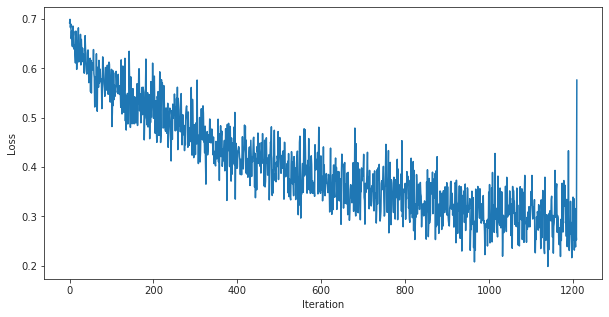

Train Loss: 0.6964
Train Loss: 0.5656
Train Loss: 0.5151
Train Loss: 0.5049
Train Loss: 0.4812
Train Loss: 0.4000
Train Loss: 0.3965
Train Loss: 0.3466
Train Loss: 0.3264
Train Loss: 0.3397
Train Loss: 0.3640
Train Loss: 0.2789
Train Loss: 0.2875


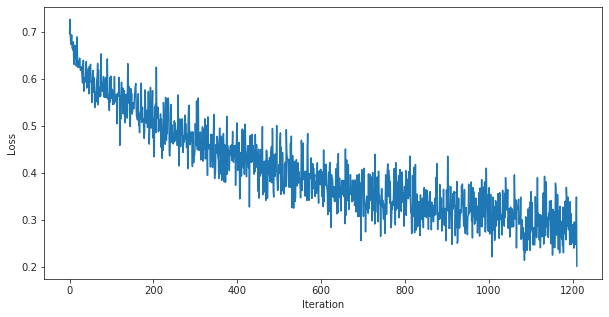

Train Loss: 0.7055
Train Loss: 0.5436
Train Loss: 0.5526
Train Loss: 0.4534
Train Loss: 0.3705
Train Loss: 0.4195
Train Loss: 0.3706
Train Loss: 0.3291
Train Loss: 0.3287
Train Loss: 0.3409
Train Loss: 0.2461
Train Loss: 0.2916
Train Loss: 0.2898


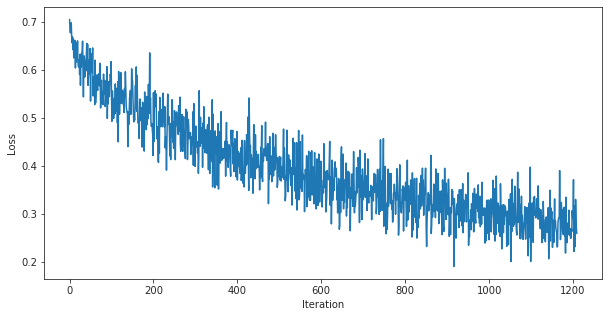

0.25007576695224404


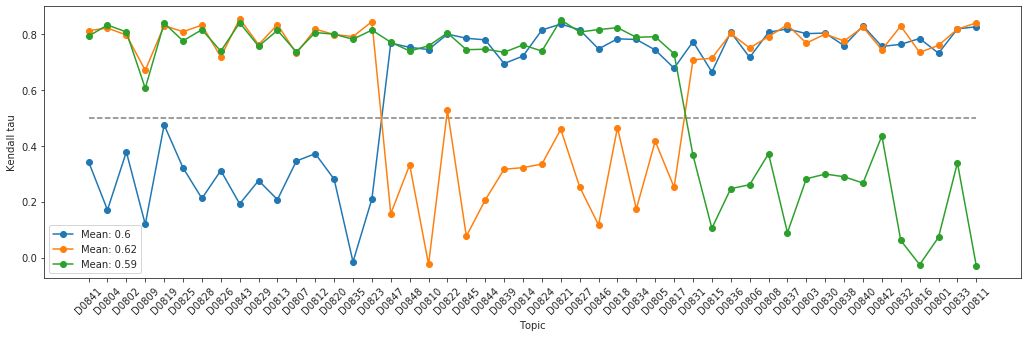

In [3]:
def execute():
    def make(shape, values, indices):
        ret = []
        for i in indices:
            t = i[1] - i[0]
            target = np.zeros(shape=shape)
            target[:t] = values[i[0]:i[1]]
            ret.extend(target.tolist())
        return ret

    M = 20
    N = 768

    topic_ids = np.array(TOPIC_IDS[DATASET_ID_TRAIN])

    dataset = defaultdict(dict)

    for topic_id in topic_ids:
        topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
        document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)

        dataset[topic_id]['document_embs'] = np.array(document_embs).mean(axis=0, keepdims=True).repeat(M, axis=0)
        dataset[topic_id]['summary_embs'] = np.array(make((M,N), summary_embs, indices))
        dataset[topic_id]['masks'] = np.array(make((M,1), np.ones(len(summary_embs)).reshape(-1,1), indices))
        dataset[topic_id]['indices'] = np.array([[i, i+1] for i in range(len(indices))]) * M
        dataset[topic_id]['pyr_scores'] = np.array(pyr_scores)
        dataset[topic_id]['summ_ids'] = np.array(summ_ids)

    tuples_data = []

    for topic_id in topic_ids:
        tuples_data.extend(make_tuples_data_for_classification(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))

    tuples_data = np.array(tuples_data)

    class TACDatasetClassification(Dataset):

        def __init__(self, data, transform):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            topic_id = self.data[idx][0]

            i1 = dataset[topic_id]['indices'][int(self.data[idx][1])]
            i2 = dataset[topic_id]['indices'][int(self.data[idx][2])]

            d  = dataset[topic_id]['document_embs']
            s1 = dataset[topic_id]['summary_embs'][i1[0]:i1[1]]
            s2 = dataset[topic_id]['summary_embs'][i2[0]:i2[1]]
            m1 = dataset[topic_id]['masks'][i1[0]:i1[1]]
            m2 = dataset[topic_id]['masks'][i2[0]:i2[1]]
            y  = float(self.data[idx][3])

            return self.transform((d, s1, s2, m1, m2, y))

    class ToTensor():
        def __call__(self, sample):
            d, s1, s2, m1, m2, y = sample

            d  = torch.tensor(d,  dtype=torch.float)
            s1 = torch.tensor(s1, dtype=torch.float)
            s2 = torch.tensor(s2, dtype=torch.float)
            m1 = torch.tensor(m1, dtype=torch.bool)
            m2 = torch.tensor(m2, dtype=torch.bool)
            y  = torch.tensor(y,  dtype=torch.float)

            return d, s1, s2, m1, m2, y

    class NeuralNetScoringPRModel(nn.Module):

        @staticmethod
        def load(fname, config):
            model = NeuralNetScoringPRModel(config)
            model.load_state_dict(torch.load(os.path.join(MODELS_DIR, fname)))
            model.eval()
            return model

        def save(self, fname):
            torch.save(self.state_dict(), os.path.join(MODELS_DIR, fname))

        def __init__(self, config):
            super(NeuralNetScoringPRModel, self).__init__()
            self.config = config
            self.layer1 = nn.Linear(self.config['D'], self.config['D'])
            self.layer2 = nn.Linear(self.config['H'], 1)
            self.sigm = nn.Sigmoid()

        def transform(self, x):
            return F.relu(self.layer1(x))

        def predict(self, d, s, m):
            x = torch.cat((self.transform(d), self.transform(s)), axis=2)
            z = self.layer2(x)
            return torch.stack([ torch.sum(z[i].masked_select(m[i])) for i in range(z.shape[0]) ])

        def forward(self, d, s1, s2, m1, m2):
            score1 = self.predict(d, s1, m1)
            score2 = self.predict(d, s2, m2)
            return self.sigm(self.config['scaling_factor'] * (score1 - score2))

    config = {
        'D': 768,
        'H': 1536,
        'scaling_factor': 1,
        'learning_rate': 1e-4,
        'batch_size': 100
    }

    transform = transforms.Compose([ToTensor()])

    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):

        topic_ids_train = topic_ids[train_index]
        topic_ids_test  = topic_ids[test_index]

        tuples_train = tuples_data[np.isin(tuples_data[:,0], topic_ids_train)]
        tuples_test  = tuples_data[np.isin(tuples_data[:,0], topic_ids_test)]

        dataset_train = TACDatasetClassification(tuples_train, transform)
        dataset_test  = TACDatasetClassification(tuples_test, transform)

        neural_net_scoring_pr_model = NeuralNetScoringPRModel(config).to(device=cuda)

        criterion = nn.BCELoss()
        optimizer = optim.Adam(neural_net_scoring_pr_model.parameters(), lr=config['learning_rate'])

        loss = []

        data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], num_workers=24, shuffle=True)

        for i, batch in enumerate(data_loader_train):            
            optimizer.zero_grad()

            d, s1, s2, m1, m2, y = batch

            y_hat = neural_net_scoring_pr_model(d.to(device=cuda),
                                                s1.to(device=cuda),
                                                s2.to(device=cuda),
                                                m1.to(device=cuda),
                                                m2.to(device=cuda))
            y_hat = y_hat.squeeze()

            L = criterion(y_hat, y.to(device=cuda))

            L.backward()

            optimizer.step()

            loss.append(L.item())

            if i % 100 == 0:
                print(f'Train Loss: {loss[-1]:.4f}')

        neural_net_scoring_pr_model.save(f'neural_net_scoring_pr_model_cv_{model_num + 1}.pt')

        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(1,1,1)
        plot_loss(ax, loss)
        plt.show()

    def experiment(model, data):
        document_embs, summary_embs, masks, indices, pyr_scores, summ_ids = data
        document_embs = torch.tensor(document_embs, dtype=torch.float).unsqueeze(0).to(device=cuda)
        metric = lambda i: model.predict(document_embs,
                                         torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).unsqueeze(0).to(device=cuda),
                                         torch.tensor(masks[i[0]:i[1]], dtype=torch.bool).to(device=cuda))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    def execute_experiment(model, dataset, topic_ids, experiment):
        scores = []
        with torch.no_grad():
            for topic_id in topic_ids:
                scores.append(experiment(model, dataset[topic_id].values()))
        return np.array(scores)

    neural_net_scoring_pr_models = [
        NeuralNetScoringPRModel.load('neural_net_scoring_pr_model_cv_1.pt', config).to(device=cuda),
        NeuralNetScoringPRModel.load('neural_net_scoring_pr_model_cv_2.pt', config).to(device=cuda),
        NeuralNetScoringPRModel.load('neural_net_scoring_pr_model_cv_3.pt', config).to(device=cuda)
    ]

    neural_net_scoring_pr_model_scores = [
        execute_experiment(neural_net_scoring_pr_models[0], dataset, topic_ids, experiment),
        execute_experiment(neural_net_scoring_pr_models[1], dataset, topic_ids, experiment),
        execute_experiment(neural_net_scoring_pr_models[2], dataset, topic_ids, experiment)
    ]

    scores = []
    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
        topic_ids_test = topic_ids[test_index]
        scores.extend(execute_experiment(neural_net_scoring_pr_models[model_num],
                                         dataset,
                                         topic_ids_test,
                                         experiment))

    print(np.mean(scores))

    x = np.arange(len(dataset.keys()))
    fig = plt.figure(figsize=(17.5,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, neural_net_scoring_pr_model_scores[0], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[0]):.2}')
    ax.plot(x, neural_net_scoring_pr_model_scores[1], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[1]):.2}')
    ax.plot(x, neural_net_scoring_pr_model_scores[2], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[2]):.2}')
    ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset.keys(), rotation=45)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Kendall tau')
    ax.legend(loc='best')
    plt.show()

execute()

Train Loss: 12.3369
Train Loss: 11.7122
Train Loss: 11.8259
Train Loss: 12.5200
Train Loss: 12.0455
Train Loss: 9.9724
Train Loss: 11.4225
Train Loss: 10.3978
Train Loss: 11.7480
Train Loss: 10.2129
Train Loss: 10.9827
Train Loss: 8.7079
Train Loss: 10.4344
Train Loss: 10.1899
Train Loss: 9.4611
Train Loss: 8.4396
Train Loss: 8.3287
Train Loss: 8.3413
Train Loss: 8.8830
Train Loss: 9.4718
Train Loss: 10.2708
Train Loss: 8.6819
Train Loss: 10.2689
Train Loss: 9.9062
Train Loss: 8.4174
Train Loss: 8.6941
Train Loss: 9.5325
Train Loss: 7.9049
Train Loss: 6.4312
Train Loss: 10.2945
Train Loss: 8.6101
Train Loss: 8.2702
Train Loss: 9.3387
Train Loss: 8.2342
Train Loss: 7.3917
Train Loss: 11.7013
Train Loss: 9.8830
Train Loss: 9.6439
Train Loss: 9.3475
Train Loss: 9.4333
Train Loss: 8.8041
Train Loss: 7.6252
Train Loss: 8.9378
Train Loss: 9.0341
Train Loss: 7.4768
Train Loss: 8.7379
Train Loss: 8.3164
Train Loss: 8.4152
Train Loss: 8.0180
Train Loss: 8.2323
Train Loss: 10.8319
Train Loss: 8.

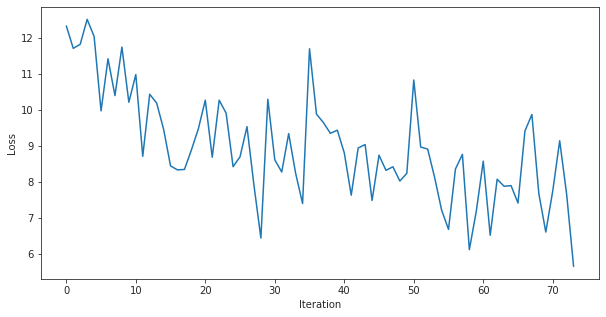

Train Loss: 16.2644
Train Loss: 15.6664
Train Loss: 13.5165
Train Loss: 11.8010
Train Loss: 12.2646
Train Loss: 11.3770
Train Loss: 9.4321
Train Loss: 12.0049
Train Loss: 10.4485
Train Loss: 10.0101
Train Loss: 9.4604
Train Loss: 10.3536
Train Loss: 10.1380
Train Loss: 9.0983
Train Loss: 14.6233
Train Loss: 13.0336
Train Loss: 14.3699
Train Loss: 10.0761
Train Loss: 10.0787
Train Loss: 9.7815
Train Loss: 14.6042
Train Loss: 13.4332
Train Loss: 15.5867
Train Loss: 11.9527
Train Loss: 8.6982
Train Loss: 7.9206
Train Loss: 9.2782
Train Loss: 7.5973
Train Loss: 8.9105
Train Loss: 8.5669
Train Loss: 9.2476
Train Loss: 8.4219
Train Loss: 9.1526
Train Loss: 8.4593
Train Loss: 7.7179
Train Loss: 7.9332
Train Loss: 7.9247
Train Loss: 8.4241
Train Loss: 8.9451
Train Loss: 8.0383
Train Loss: 7.9118
Train Loss: 9.3915
Train Loss: 8.0033
Train Loss: 8.6426
Train Loss: 9.8518
Train Loss: 7.6227
Train Loss: 8.0707
Train Loss: 9.6329
Train Loss: 7.8039
Train Loss: 7.8618
Train Loss: 8.1574
Train Loss:

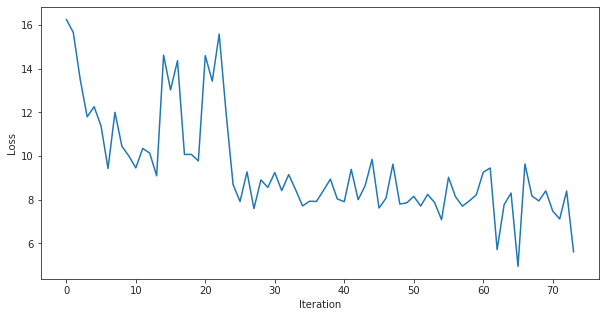

Train Loss: 15.0490
Train Loss: 15.0657
Train Loss: 16.8121
Train Loss: 12.9169
Train Loss: 13.5484
Train Loss: 12.8067
Train Loss: 11.7237
Train Loss: 10.0019
Train Loss: 11.2545
Train Loss: 10.7103
Train Loss: 8.0566
Train Loss: 11.2323
Train Loss: 9.7605
Train Loss: 9.0689
Train Loss: 9.8554
Train Loss: 9.7420
Train Loss: 8.9756
Train Loss: 8.8004
Train Loss: 10.3666
Train Loss: 9.3758
Train Loss: 9.5132
Train Loss: 10.6727
Train Loss: 7.8345
Train Loss: 8.7657
Train Loss: 8.9456
Train Loss: 7.9450
Train Loss: 8.4015
Train Loss: 8.4654
Train Loss: 7.6091
Train Loss: 8.4272
Train Loss: 8.2292
Train Loss: 8.7653
Train Loss: 9.2830
Train Loss: 8.4608
Train Loss: 7.8520
Train Loss: 8.1604
Train Loss: 7.4697
Train Loss: 9.3533
Train Loss: 6.7556
Train Loss: 10.1935
Train Loss: 9.9574
Train Loss: 9.3965
Train Loss: 7.6525
Train Loss: 10.1981
Train Loss: 8.0509
Train Loss: 7.7700
Train Loss: 7.4078
Train Loss: 8.2879
Train Loss: 8.1910
Train Loss: 10.0898
Train Loss: 8.5031
Train Loss: 10.

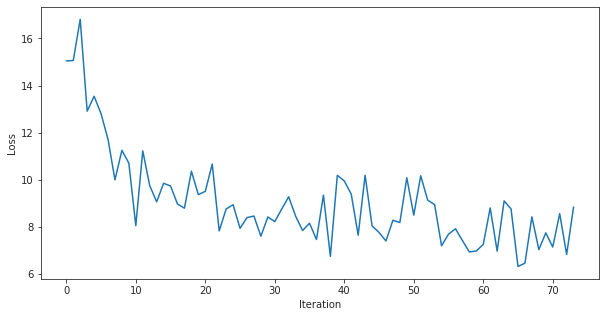

-0.00961615935777495


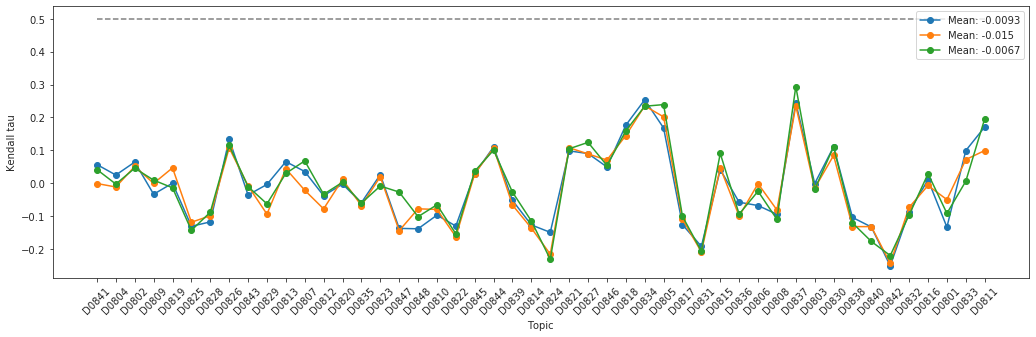

In [4]:
def execute():
    evaluator = rouge.Rouge(metrics=['rouge-n'],
                            max_n=2,
                            length_limit=100,
                            length_limit_type='words')

    topic_ids = np.array(TOPIC_IDS[DATASET_ID_TRAIN])

    dataset = defaultdict(dict)

    for topic_id in topic_ids:
        topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
        document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)

        dataset[topic_id]['document_embs'] = np.array(document_embs)
        dataset[topic_id]['summary_embs'] = np.array(summary_embs)
        dataset[topic_id]['indices'] = np.array(indices)
        dataset[topic_id]['pyr_scores'] = np.array(pyr_scores)
        dataset[topic_id]['summ_ids'] = np.array(summ_ids)

    def make_tuples_data_for_regression(base_data_dir, dataset_id, topic_id):
        topic = load_data(base_data_dir, dataset_id, encoded=False)[topic_id]
        documents, summaries, indices, _, _ = extract(topic)
        reference_summaries = summaries[indices[-4][0]:indices[-1][1]]

        data = []
        n = len(documents) 
        for i in range(n):
            y = evaluator.get_scores(documents[i], reference_summaries)['rouge-2']['r']
            data.append((topic_id, i, y))

        return data

    tuples_data = []

    for topic_id in topic_ids:
        tuples_data.extend(make_tuples_data_for_regression(BASE_DATA_DIR, DATASET_ID_TRAIN, topic_id))

    tuples_data = np.array(tuples_data)

    class TACDatasetRegression(Dataset):

        def __init__(self, data, transform):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            topic_id = self.data[idx][0]

            i = int(self.data[idx][1])

            s = dataset[topic_id]['document_embs'][i]
            y = float(self.data[idx][2])

            return self.transform((s, y))

    class ToTensor():

        def __call__(self, sample):
            s, y = sample

            s = torch.tensor(s, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float)

            return s, y

    config = {
        'D': 768,
        'p': 2,
        'blur': .05,
        'scaling': .9,
        'learning_rate': 1e-2,
        'batch_size': 100
    }

    class NeuralNetRougeRegModel(nn.Module):

        @staticmethod
        def load(fname, config):
            model = NeuralNetRougeRegModel(config)
            model.load_state_dict(torch.load(os.path.join(MODELS_DIR, fname)))
            model.eval()
            return model

        def save(self, fname):
            torch.save(self.state_dict(), os.path.join(MODELS_DIR, fname))

        def __init__(self, config):
            super(NeuralNetRougeRegModel, self).__init__()
            self.config = config
            self.sinkhorn = SamplesLoss(loss='sinkhorn', p=self.config['p'], blur=self.config['blur'], scaling=self.config['scaling'])
            self.layer = nn.Linear(self.config['D'], self.config['D'])

        def transform(self, x):
            return F.relu(self.layer(x))

        def predict(self, d, s):
            return self.sinkhorn(self.transform(d), self.transform(s))

        def forward(self, sent):
            return torch.norm(self.transform(sent), p=2, dim=1)

    transform = transforms.Compose([ToTensor()])

    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):

        topic_ids_train = topic_ids[train_index]
        topic_ids_test  = topic_ids[test_index]

        tuples_train = tuples_data[np.isin(tuples_data[:,0], topic_ids_train)]
        tuples_test  = tuples_data[np.isin(tuples_data[:,0], topic_ids_test)]

        dataset_train = TACDatasetRegression(tuples_train, transform)
        dataset_test  = TACDatasetRegression(tuples_test, transform)

        neural_net_rouge_reg_model = NeuralNetRougeRegModel(config).to(device=cuda)

        criterion = nn.MSELoss()
        optimizer = optim.SGD(neural_net_rouge_reg_model.parameters(), lr=config['learning_rate'])

        loss = []

        data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], num_workers=24, shuffle=True)

        for i, batch in enumerate(data_loader_train):            
            optimizer.zero_grad()

            s, y = batch

            y_hat = neural_net_rouge_reg_model(s.to(device=cuda))
            y = -torch.log(y + 0.00001).to(device=cuda)

            L = criterion(y_hat, y)

            L.backward()

            optimizer.step()

            loss.append(L.item())

            print(f'Train Loss: {loss[-1]:.4f}')

        neural_net_rouge_reg_model.save(f'neural_net_rouge_reg_model_cv_{model_num + 1}.pt')

        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(1,1,1)
        plot_loss(ax, loss)
        plt.show()

    def experiment(model, data):
        document_embs, summary_embs, indices, pyr_scores, summ_ids = data
        document_embs = torch.tensor(document_embs, dtype=torch.float).to(device=cuda)
        metric = lambda i: model.predict(document_embs,
                                         torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).to(device=cuda))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    def execute_experiment(model, dataset, topic_ids, experiment):
        scores = []
        with torch.no_grad():
            for topic_id in topic_ids:
                scores.append(experiment(model, dataset[topic_id].values()))
        return np.array(scores)

    neural_net_rouge_reg_models = [
        NeuralNetRougeRegModel.load('neural_net_rouge_reg_model_cv_1.pt', config).to(device=cuda),
        NeuralNetRougeRegModel.load('neural_net_rouge_reg_model_cv_2.pt', config).to(device=cuda),
        NeuralNetRougeRegModel.load('neural_net_rouge_reg_model_cv_3.pt', config).to(device=cuda)
    ]

    neural_net_rouge_reg_model_scores = [
        execute_experiment(neural_net_rouge_reg_models[0], dataset, topic_ids, experiment),
        execute_experiment(neural_net_rouge_reg_models[1], dataset, topic_ids, experiment),
        execute_experiment(neural_net_rouge_reg_models[2], dataset, topic_ids, experiment)
    ]

    scores = []
    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
        topic_ids_test = topic_ids[test_index]
        scores.extend(execute_experiment(neural_net_rouge_reg_models[model_num],
                                         dataset,
                                         topic_ids_test,
                                         experiment))

    print(np.mean(scores))

    x = np.arange(len(dataset.keys()))
    fig = plt.figure(figsize=(17.5,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, neural_net_rouge_reg_model_scores[0], '-o', label=f'Mean: {np.mean(neural_net_rouge_reg_model_scores[0]):.2}')
    ax.plot(x, neural_net_rouge_reg_model_scores[1], '-o', label=f'Mean: {np.mean(neural_net_rouge_reg_model_scores[1]):.2}')
    ax.plot(x, neural_net_rouge_reg_model_scores[2], '-o', label=f'Mean: {np.mean(neural_net_rouge_reg_model_scores[2]):.2}')
    ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset.keys(), rotation=45)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Kendall tau')
    ax.legend(loc='best')
    plt.show()

execute()